In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import os
import datetime
import pandas as pd
from scipy import stats

from palettable.colorbrewer.diverging import *
from palettable.colorbrewer.sequential import *
from calendar import monthrange

from osgeo import osr
import pyproj
from pyproj import Geod
from pyproj import Proj, transform
from fiona.crs import from_epsg

# Load Alpine3D data sets

In [2]:
ds = xr.open_mfdataset("/scratch/summit/erke2265/PRODUCTION/*WN/output/grids/*")

/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  """Entry point for launching an IPython kernel.
/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


In [3]:
n_trim = 15 # 15
ds = ds.isel(easting=slice(n_trim, -n_trim))
ds = ds.isel(northing=slice(n_trim, -n_trim))
ds

<xarray.Dataset>
Dimensions:                (easting: 168, northing: 107, time: 52607)
Coordinates:
  * northing               (northing) float32 -108500.0 -107500.0 ... -2500.0
  * easting                (easting) float32 -1542500.0 ... -1375500.0
  * time                   (time) datetime64[ns] 2015-01-01T01:00:00 ... 2020-12-31T23:00:00
Data variables:
    dw                     (time, northing, easting) float32 dask.array<chunksize=(8759, 107, 168), meta=np.ndarray>
    ERODEDMASS             (time, northing, easting) float32 dask.array<chunksize=(8759, 107, 168), meta=np.ndarray>
    ET                     (time, northing, easting) float32 dask.array<chunksize=(8759, 107, 168), meta=np.ndarray>
    snd                    (time, northing, easting) float32 dask.array<chunksize=(8759, 107, 168), meta=np.ndarray>
    rlds                   (time, northing, easting) float32 dask.array<chunksize=(8759, 107, 168), meta=np.ndarray>
    rsds                   (time, northing, easting) float32 dask.array<chunksize=(8759, 107, 168), meta=np.ndarray>
    MS_EROSION_DHS         (time, northing, easting) float32 dask.array<chunksize=(8759, 107, 168), meta=np.ndarray>
    MS_HNW                 (time, northing, easting) float32 dask.array<chunksize=(8759, 107, 168), meta=np.ndarray>
    MS_SETTLING_DHS        (time, northing, easting) float32 dask.array<chunksize=(8759, 107, 168), meta=np.ndarray>
    MS_SNOWPACK_RUNOFF     (time, northing, easting) float32 dask.array<chunksize=(8759, 107, 168), meta=np.ndarray>
    MS_SNOW_DHS            (time, northing, easting) float32 dask.array<chunksize=(8759, 107, 168), meta=np.ndarray>
    MS_SUBL_DHS            (time, northing, easting) float32 dask.array<chunksize=(8759, 107, 168), meta=np.ndarray>
    MS_WIND                (time, northing, easting) float32 dask.array<chunksize=(8759, 107, 168), meta=np.ndarray>
    pr                     (time, northing, easting) float32 dask.array<chunksize=(8759, 107, 168), meta=np.ndarray>
    hur                    (time, northing, easting) float32 dask.array<chunksize=(8759, 107, 168), meta=np.ndarray>
    RHO1                   (time, northing, easting) float32 dask.array<chunksize=(8759, 107, 168), meta=np.ndarray>
    RHO2                   (time, northing, easting) float32 dask.array<chunksize=(8759, 107, 168), meta=np.ndarray>
    RHO3                   (time, northing, easting) float32 dask.array<chunksize=(8759, 107, 168), meta=np.ndarray>
    RHO4                   (time, northing, easting) float32 dask.array<chunksize=(8759, 107, 168), meta=np.ndarray>
    RHO5                   (time, northing, easting) float32 dask.array<chunksize=(8759, 107, 168), meta=np.ndarray>
    SFC_SUBL               (time, northing, easting) float32 dask.array<chunksize=(8759, 107, 168), meta=np.ndarray>
    SURF_ALB               (time, northing, easting) float32 dask.array<chunksize=(8759, 107, 168), meta=np.ndarray>
    swe                    (time, northing, easting) float32 dask.array<chunksize=(8759, 107, 168), meta=np.ndarray>
    ta                     (time, northing, easting) float32 dask.array<chunksize=(8759, 107, 168), meta=np.ndarray>
    ts                     (time, northing, easting) float32 dask.array<chunksize=(8759, 107, 168), meta=np.ndarray>
    ws                     (time, northing, easting) float32 dask.array<chunksize=(8759, 107, 168), meta=np.ndarray>
    WINDEROSIONDEPOSITION  (time, northing, easting) float32 dask.array<chunksize=(8759, 107, 168), meta=np.ndarray>
Attributes:
    date_created:              2021-11-12
    creator_name:              erke2265
    source:                    MeteoIO-3.00
    history:                   2021-11-12T23:24:51Z, erke2265@shas0406.rc.int...
    keywords_vocabulary:       AGU Index Terms
    keywords:                  Cryosphere, Mass Balance, Energy Balance, Atmo...
    title:                     Gridded data for various parameters and timesteps
    institution:               colorado.edu
    product

# Map of 2015 - 2020 mean SMB

In [4]:
n_years = 6
smb = 1000 * (ds['swe'][-1,:,:] - ds['swe'][0,:,:]) / n_years # Units mm w.e. per year

In [5]:
min_smb = smb.min().values
max_smb = smb.max().values
color_lim = np.max([np.abs(min_smb), max_smb])

print(min_smb)
print(max_smb)
print(color_lim)

12.030284
1215.6105
1215.6105


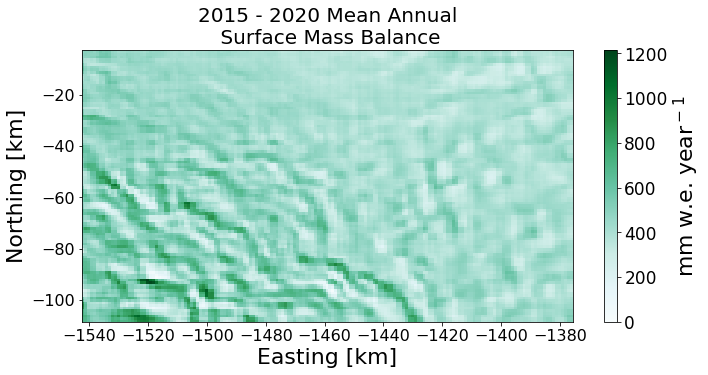

In [6]:
# colormap = BrBG_11.mpl_colormap
colormap = BuGn_9.mpl_colormap

plt.figure(figsize=(11, 5))
# plt.pcolor(ds['easting']/1000, ds['northing']/1000, smb, cmap=colormap, vmin=-color_lim, vmax=color_lim, linewidth=0, rasterized=True)
plt.pcolor(ds['easting']/1000, ds['northing']/1000, smb, cmap=colormap, vmin=0, vmax=color_lim, linewidth=0, rasterized=True)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=17)
cb.set_label("mm w.e. year$^-$$^1$", fontsize=22)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Easting [km]", fontsize=22)
plt.ylabel("Northing [km]", fontsize=22)
plt.title("2015 - 2020 Mean Annual\n Surface Mass Balance", fontsize=20)
plt.savefig("images/smb_mean.pdf", format='pdf', dpi=100, bbox_inches='tight')

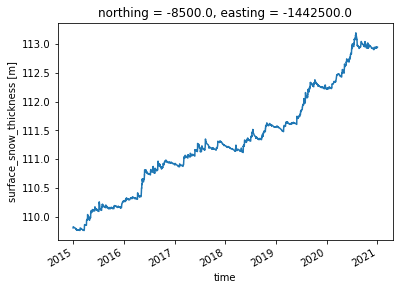

In [7]:
ds['snd'][:,100,100].plot()

# Transect and scatter plot against observations (A3D and MERRA2)
Note that I still need to add M2, but this is dependent on calculating 2015 - 2020 averages

In [8]:
obs_lat, obs_lon, obs_accumulation, relative_accumulation, relative_accumulation_error = \
    np.loadtxt("/pl/active/nasa_smb/Data/Accumulation_Data_Product.csv", skiprows=1, delimiter=',', unpack=True)

In [9]:
# Source and target EPSG
src = osr.SpatialReference()
tgt = osr.SpatialReference()
src.ImportFromEPSG(4326) # WGS-84
tgt.ImportFromEPSG(3031) # South Polar Stereo

# Define transformation
transform = osr.CoordinateTransformation(src, tgt)

# Initialize arrays
obs_X = np.zeros(len(obs_lon)); obs_X[:] = np.nan
obs_Y = np.zeros(len(obs_lon)); obs_Y[:] = np.nan

# Perform transformation
for j in range(0, len(obs_X)):
    coords = transform.TransformPoint(obs_lat[j], obs_lon[j]) # Lat, Lon
    obs_X[j], obs_Y[j] = coords[0:2]

In [10]:
domain_left = ds['easting'].min()
domain_right = ds['easting'].max()
domain_bottom = ds['northing'].min()
domain_top = ds['northing'].max()

In [11]:
# Function to get indices of observations inside of the model domain
def get_domain_obs(obsX, obsY, obs_accum, domain_left, domain_right, domain_bottom, domain_top, obs_lat, obs_lon):
    '''
    Find obs whose X and Y are:
        X: greater than domain_left and less than domain_right
        Y: greater than domain_bottom and less than domain_top
    ''' 
    filter_func = np.vectorize(lambda obsX, obsY: obsX <= domain_right and obsX >= domain_left and obsY >= domain_bottom and obsY <= domain_top)
    indices = filter_func(obsX, obsY)
    obs_accum_filter = obs_accum[indices]
    obsX_filter = obsX[indices]
    obsY_filter = obsY[indices]
    obs_lat_filter = obs_lat[indices]
    obs_lon_filter = obs_lon[indices]
    
    return obsX_filter, obsY_filter, obs_accum_filter, obs_lat_filter, obs_lon_filter

# # Retrieve observations
obs_X, obs_Y, obs_accumulation, obs_lat, obs_lon = get_domain_obs(obs_X, obs_Y, obs_accumulation, domain_left, domain_right, domain_bottom, domain_top, obs_lat, obs_lon)

In [12]:
# Calculate seconds in each month from 2015 - 2020
seconds = np.zeros(72); seconds[:] = np.nan
count = -1
for year in range(2015, 2020 + 1):
    for month in range(1, 12 + 1):
        count = count + 1
        tmp = monthrange(year, month)
        seconds[count] = float(tmp[1]) * 24 * 60 * 60

# Path
data_path = "/scratch/summit/erke2265/MERRA2_monthly/"

# Precipitation
sn = xr.open_mfdataset(data_path + "PRECSN_monthly_*.nc", combine='nested', concat_dim='time')
ls = xr.open_mfdataset(data_path + "PRECLS_monthly_*.nc", combine='nested', concat_dim='time')
cu = xr.open_mfdataset(data_path + "PRECCU_monthly_*.nc", combine='nested', concat_dim='time')

# Evaporation 
evap = xr.open_mfdataset(data_path + "EVAP_monthly_*.nc", combine='nested', concat_dim='time')

# SMB
M2_smb = sn['PRECSN'] + ls['PRECLS'] + cu['PRECCU'] - evap['EVAP']
M2_smb = M2_smb.mean(dim='month').mean(dim='time') * seconds.mean() * 12

tgt_lon = xr.DataArray(obs_lon, dims="points")
tgt_lat = xr.DataArray(obs_lat, dims="points")
M2_transect = M2_smb.sel(lat=tgt_lat, lon=tgt_lon, method='nearest')

In [13]:
tgt_x = xr.DataArray(obs_X, dims="points")
tgt_y = xr.DataArray(obs_Y, dims="points")

a3d_transect =  smb.sel(northing=tgt_y, easting=tgt_x, method='nearest')

# Indices to plot
ind0 = 660
indf = 2000
indices = np.arange(ind0, indf)

In [14]:
# Calculate distance along track (dat)
dat = np.zeros(len(indices)); dat[:] = np.nan
x0 = obs_X[ind0]; y0 = obs_Y[ind0]
count = -1 # Add hock index counter 

for j in range(ind0, indf):
    count = count + 1
    dat[count] = np.sqrt(np.square(obs_X[j] - x0) + np.square(obs_Y[j] - y0)) / 1000

460.6147720202481
503.61725
410.05612


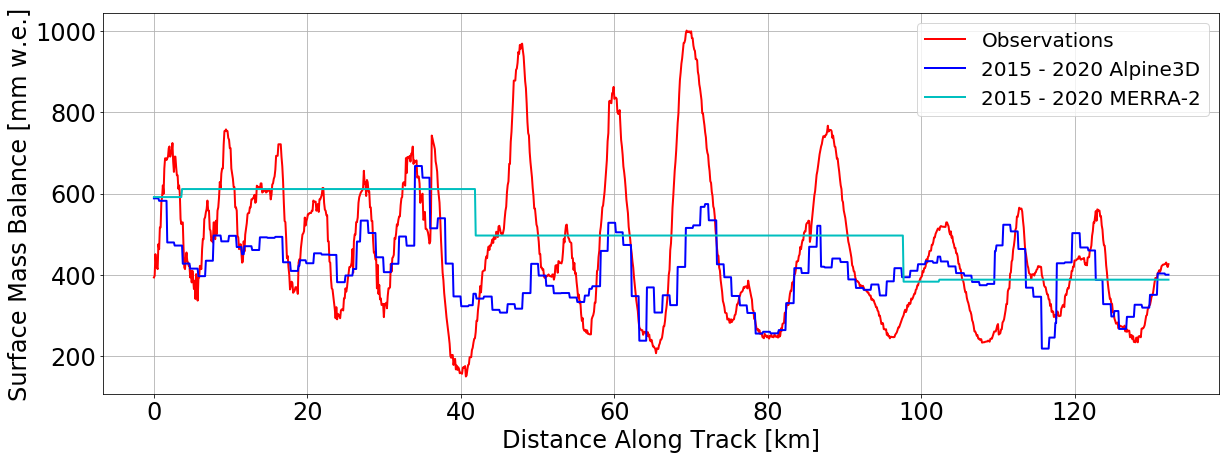

In [15]:
plt.figure(figsize=(20,7))
plt.plot(dat, 1000*obs_accumulation[indices], 'r', label='Observations', linewidth=2)
plt.plot(dat, a3d_transect[indices], 'b', label='2015 - 2020 Alpine3D', linewidth=2)
plt.plot(dat, M2_transect[indices], 'c', label='2015 - 2020 MERRA-2', linewidth=2)
plt.grid()
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.ylabel("Surface Mass Balance [mm w.e.]", fontsize=24)
plt.xlabel("Distance Along Track [km]", fontsize=24)
plt.legend(fontsize=20)
plt.savefig('images/2015-2020_transect.pdf', format='pdf', dpi=100)
print(1000*obs_accumulation[indices].mean())
print(M2_transect[indices].mean().values)
print(a3d_transect[indices].mean().values)

In [16]:
print(1000*obs_accumulation[indices].mean())
print(M2_transect[indices].mean().values)
print(a3d_transect[indices].mean().values)

460.6147720202481
503.61725
410.05612


In [37]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def pearsonr_ci(x, y, ci=95, n_boots=10000):
    x = np.asarray(x)
    y = np.asarray(y)
    
   # (n_boots, n_observations) paired arrays
    rand_ixs = np.random.randint(0, x.shape[0], size=(n_boots, x.shape[0]))
    x_boots = x[rand_ixs]
    y_boots = y[rand_ixs]
    
    # differences from mean
    x_mdiffs = x_boots - x_boots.mean(axis=1)[:, None]
    y_mdiffs = y_boots - y_boots.mean(axis=1)[:, None]
    
    # sums of squares
    x_ss = np.einsum('ij, ij -> i', x_mdiffs, x_mdiffs)
    y_ss = np.einsum('ij, ij -> i', y_mdiffs, y_mdiffs)
    
    # pearson correlations
    r_boots = np.einsum('ij, ij -> i', x_mdiffs, y_mdiffs) / np.sqrt(x_ss * y_ss)
    
    # upper and lower bounds for confidence interval
    ci_low = np.percentile(r_boots, (100 - ci) / 2)
    ci_high = np.percentile(r_boots, (ci + 100) / 2)
    return ci_low, ci_high

In [38]:
spacing = 10
obs_convulation = 1000 * np.convolve(obs_accumulation[indices], np.ones(spacing)/spacing, mode='valid')[::spacing]
M2_convulation = np.convolve(M2_transect[indices], np.ones(spacing)/spacing, mode='valid')[::spacing]
A3D_convulation = np.convolve(a3d_transect[indices], np.ones(spacing)/spacing, mode='valid')[::spacing]


In [39]:
x_1_to_1 = [-9999, 9999]
y_1_to_1 = [-9999, 9999]

p = 3.5080746129064283e-12
R^2 = 0.307797692329554
RMSE = 152.67863456076182
Average Bias = 107.6129867218794
Linear Fit Slope = 0.2546274709712803


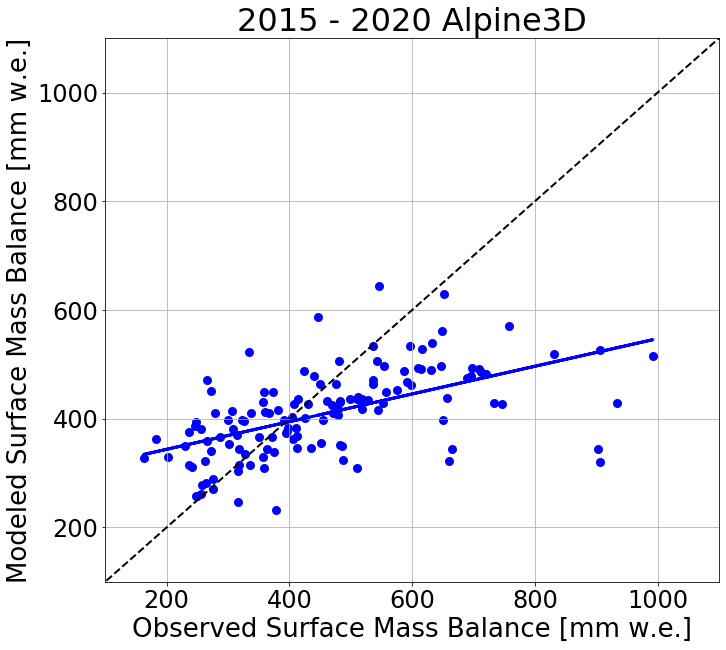

In [40]:
x = obs_convulation
y = A3D_convulation
res = stats.linregress(x, y)

plt.figure(figsize=(11,10))
plt.scatter(x, y, c='b', linewidth=3)
plt.plot(x, res.intercept + res.slope*x, 'b', label='fitted line', linewidth=3)
plt.plot(x_1_to_1, y_1_to_1, 'k--', linewidth=2)
plt.xlim([100, 1100])
plt.ylim([100, 1100])
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.grid()
plt.title("2015 - 2020 Alpine3D", fontsize=32)
plt.ylabel("Modeled Surface Mass Balance [mm w.e.]", fontsize=26)
plt.xlabel("Observed Surface Mass Balance [mm w.e.]", fontsize=26)
print("p = " + str(res.pvalue))
print("R^2 = " +str(res.rvalue**2))
print("RMSE = " + str(rmse(x, y)))
print("Average Bias = " + str(np.mean(np.abs(y - x))))
print("Linear Fit Slope = " + str(res.slope))
plt.savefig('images/2015-2020_Alpine3D_Scatter.pdf', format='pdf', dpi=100)

In [41]:
ci_low, ci_high = pearsonr_ci(x, y)
print(ci_low**2)
print(res.rvalue**2)
print(ci_high**2)

0.16897031894931908
0.307797692329554
0.4665297961699146


p = 0.0025257212689364923
R^2 = 0.06701465022838443
RMSE = 176.12483171117935
Average Bias = 137.71544975407357
Linear Fit Slope = 0.1265101027661884


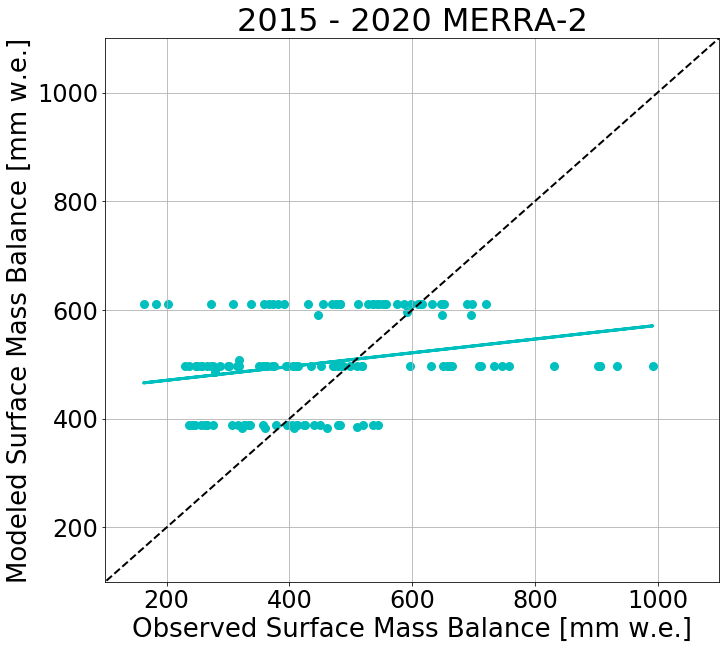

In [42]:
x = obs_convulation
y = M2_convulation
res = stats.linregress(x, y)

plt.figure(figsize=(11,10))
plt.scatter(x, y, c='c', linewidth=3)
plt.plot(x, res.intercept + res.slope*x, 'c', label='fitted line', linewidth=3)
plt.plot(x_1_to_1, y_1_to_1, 'k--', linewidth=2)
plt.xlim([100, 1100])
plt.ylim([100, 1100])
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.grid()
plt.title("2015 - 2020 MERRA-2", fontsize=32)
plt.ylabel("Modeled Surface Mass Balance [mm w.e.]", fontsize=26)
plt.xlabel("Observed Surface Mass Balance [mm w.e.]", fontsize=26)
print("p = " + str(res.pvalue))
print("R^2 = " +str(res.rvalue**2))
print("RMSE = " + str(rmse(x, y)))
print("Average Bias = " + str(np.mean(np.abs(y - x))))
print("Linear Fit Slope = " + str(res.slope))
plt.savefig('images/2015-2020_M2_Scatter.pdf', format='pdf', dpi=100)

In [43]:
ci_low, ci_high = pearsonr_ci(x, y)
print(ci_low**2)
print(res.rvalue**2)
print(ci_high**2)
print(ci_high**2 - res.rvalue**2)
print(res.rvalue**2 - ci_low**2)

0.017005985341249516
0.06701465022838443
0.1544104819814782
0.08739583175309376
0.050008664887134915
